In [43]:
# Connecting to clickhouse on remote server
import clickhouse_connect
clickhouse_client = clickhouse_connect.get_client(host='localhost')

DATASET_DIR = "throughput_est_v2_dataset"

In [44]:
import heapq
def moving_average(arr, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(arr, weights, mode='valid')

def get_throughput(series):
    W = 10
    arr = series.to_numpy()
    mv_avg = moving_average(arr, W)
    largest_numbers = heapq.nlargest(W, mv_avg)
    return sum(largest_numbers) / W

In [45]:
import os
import glob
if not os.path.exists(DATASET_DIR):
    os.mkdir(DATASET_DIR)
wgn_files = glob.glob(os.path.join(DATASET_DIR, "df_wgn_*.parquet"))
print(wgn_files)

[]


In [46]:
query = f"""
    SELECT *
    FROM wgn
    WHERE Direction = 0
    ORDER BY TsTaiNs
"""
df_wgn =  clickhouse_client.query_df(query)
print(df_wgn)
df_wgn['NoiseChangedCounter'] = 0
df_wgn['NoiseChangedCounter'] = (df_wgn['NoiseLevelDb'] != df_wgn['NoiseLevelDb'].shift()).cumsum() - 1
print(df_wgn)

                                 TestId             TsTaiNs  AdjDistanceDb  \
0      e34192396cb1402bb3355528b6dee0e7 2025-04-26 12:33:25            0.0   
1      e34192396cb1402bb3355528b6dee0e7 2025-04-26 12:33:26            0.0   
2      e34192396cb1402bb3355528b6dee0e7 2025-04-26 12:33:27            0.0   
3      e34192396cb1402bb3355528b6dee0e7 2025-04-26 12:33:28            0.0   
4      e34192396cb1402bb3355528b6dee0e7 2025-04-26 12:33:29            0.0   
...                                 ...                 ...            ...   
35695  4459c6f08ce94cd48659a1815d4c8ad7 2025-04-28 07:32:31           25.0   
35696  4459c6f08ce94cd48659a1815d4c8ad7 2025-04-28 07:32:32           25.0   
35697  4459c6f08ce94cd48659a1815d4c8ad7 2025-04-28 07:32:33           25.0   
35698  4459c6f08ce94cd48659a1815d4c8ad7 2025-04-28 07:32:34           25.0   
35699  4459c6f08ce94cd48659a1815d4c8ad7 2025-04-28 07:32:35           25.0   

       NoiseLevelDb  Direction  TargetThroughputMbps  Throughpu

     AdjDistanceDb  NoiseLevelDb  NoiseChangedCounter           BeginTime  \
44             0.0         -37.5                   15 2025-04-26 15:52:17   
59             0.0         -30.0                    7 2025-04-26 13:26:43   
65            20.0        -100.0                   85 2025-04-27 15:00:22   
107           30.0         -44.0                   76 2025-04-27 12:35:04   

                EndTime  TargetThroughputMbps  MaxThroughputMbps  
44  2025-04-26 16:03:43             19.615385          33.867853  
59  2025-04-26 14:12:30             18.357143          14.129158  
65  2025-04-27 15:04:14              5.166667          16.252905  
107 2025-04-27 12:36:14              0.500000           1.121100  
     AdjDistanceDb  NoiseLevelDb  NoiseChangedCounter           BeginTime  \
0              0.0        -100.0                    0 2025-04-26 12:33:25   
1              0.0         -90.0                    1 2025-04-26 12:41:01   
2              0.0         -80.0                

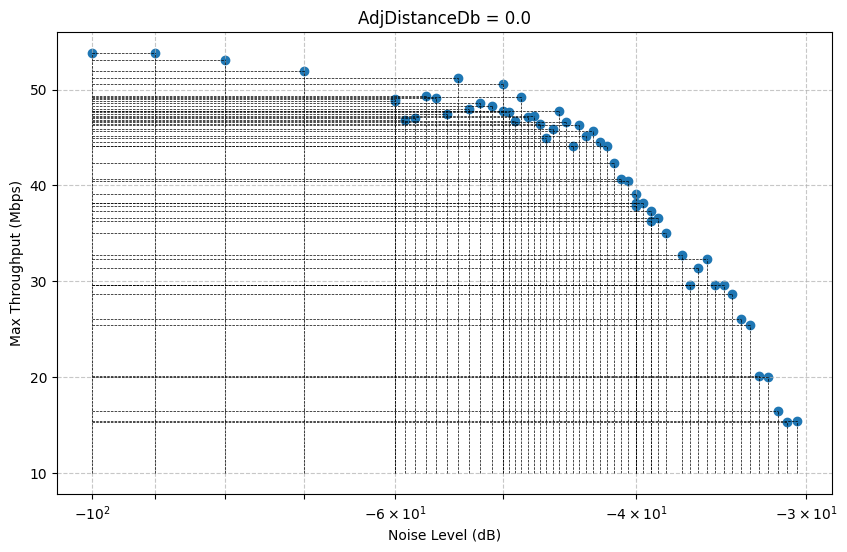

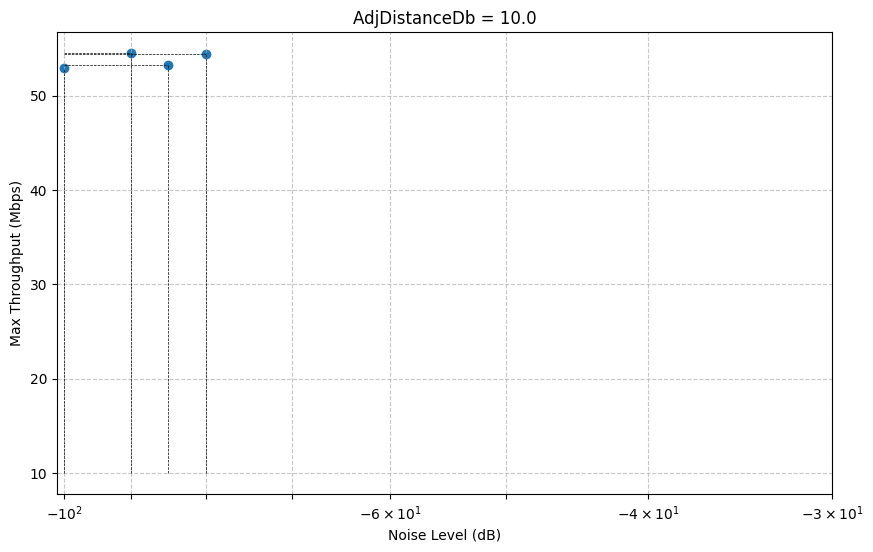

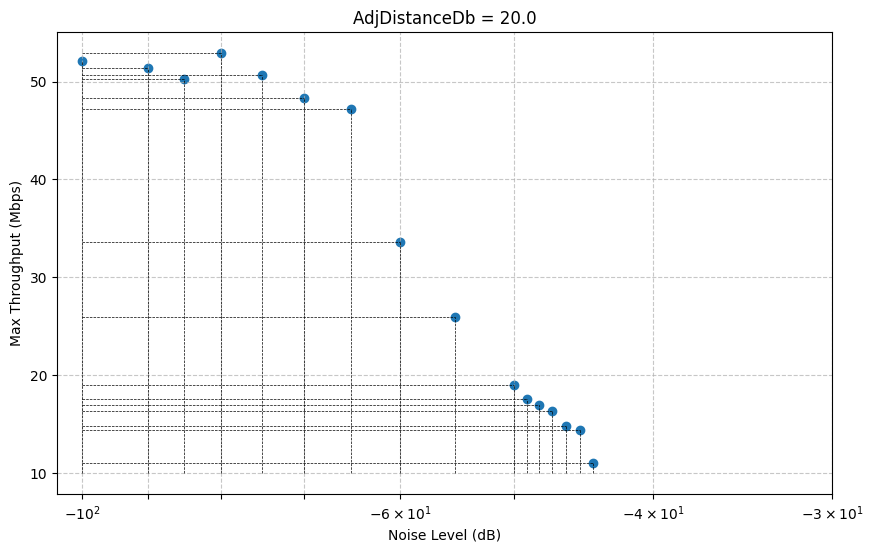

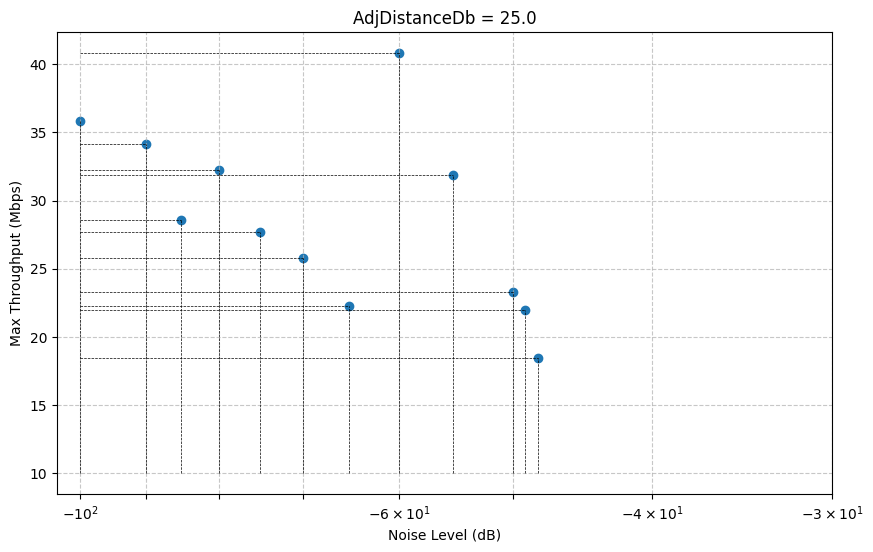

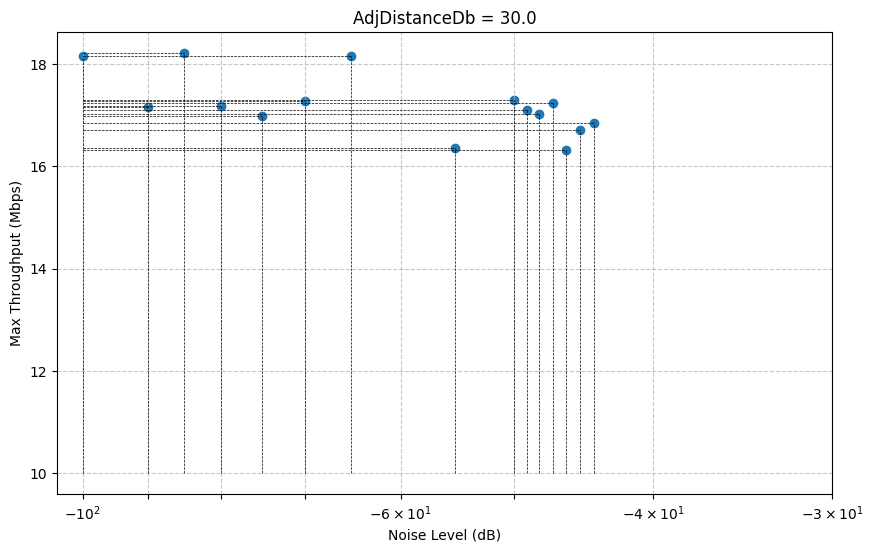

In [47]:
import numpy as np
import matplotlib.pyplot as plt

df_dataset_valid = df_wgn.groupby(['AdjDistanceDb', 'NoiseLevelDb', 'NoiseChangedCounter']).agg(
    BeginTime=('TsTaiNs', 'min'),
    EndTime=('TsTaiNs', 'max'),
    TargetThroughputMbps=('TargetThroughputMbps', 'mean'),
    MaxThroughputMbps=('ThroughputMbps', get_throughput),
).reset_index()

df_dataset_invalid = df_dataset_valid[~np.isclose(df_dataset_valid['TargetThroughputMbps'], 23.090909, rtol=1e-5)]
print(df_dataset_invalid)

df_dataset_valid = df_dataset_valid[np.isclose(df_dataset_valid['TargetThroughputMbps'], 23.090909, rtol=1e-5)]
df_dataset_valid = df_dataset_valid.sort_values('BeginTime').reset_index(drop=True)
print(df_dataset_valid)

unique_distances = np.sort(df_dataset_valid['AdjDistanceDb'].unique())

for distance in unique_distances:
    plt.figure(figsize=(10, 6))
    distance_data = df_dataset_valid[df_dataset_valid['AdjDistanceDb'] == distance]

    plt.scatter(distance_data['NoiseLevelDb'], distance_data['MaxThroughputMbps'])

    for x, y in zip(distance_data['NoiseLevelDb'], distance_data['MaxThroughputMbps']):
        plt.plot([x, x], [10, y], 'k--', linewidth=0.5)
        plt.plot([-100, x], [y, y], 'k--', linewidth=0.5)

    plt.xlabel('Noise Level (dB)')
    plt.ylabel('Max Throughput (Mbps)')
    plt.title(f'AdjDistanceDb = {distance}')
    plt.xscale('symlog')
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.xticks([-100, -90, -80, -70, -60, -50, -40, -30])
    plt.show()

In [48]:
import numpy as np
import pandas as pd
import pickle
import datetime

dataset = pd.DataFrame()
# ignores = [-90, -70, -50, -39, -37, -35, -33, -31, -29, -27, -25, -23, -21, -19, -17, -15, -13.8, -13.4, -12.8, -12.4, -11.8, -11.4, -10.8, -10.4, -9.8, -9.4, -8.8, -8.4, -7.8, -7.4]
ignores = []
wgn_files = glob.glob(os.path.join(DATASET_DIR, "df_*_wgn.parquet"))
mac_files = glob.glob(os.path.join(DATASET_DIR, "df_*_mac.parquet"))
fapi_files = glob.glob(os.path.join(DATASET_DIR, "df_*_fapi.parquet"))
fh_files = glob.glob(os.path.join(DATASET_DIR, "df_*_fh.parquet"))
print(wgn_files)

for noise_id_idx, noise_record in df_dataset_valid.iterrows():
    wgn_file = f"{DATASET_DIR}/df_{noise_id_idx:04d}_{noise_record.AdjDistanceDb}_{noise_record.NoiseLevelDb}_wgn.parquet"
    mac_file = f"{DATASET_DIR}/df_{noise_id_idx:04d}_{noise_record.AdjDistanceDb}_{noise_record.NoiseLevelDb}_mac.parquet"
    fapi_file = f"{DATASET_DIR}/df_{noise_id_idx:04d}_{noise_record.AdjDistanceDb}_{noise_record.NoiseLevelDb}_fapi.parquet"
    fh_file =  f"{DATASET_DIR}/df_{noise_id_idx:04d}_{noise_record.AdjDistanceDb}_{noise_record.NoiseLevelDb}_fh.parquet"
    print(f'-- Creating {wgn_file}, {mac_file}, {fapi_file}, {fh_file}')
    # continue
    indent = 4
    if wgn_file in wgn_files and mac_file in mac_files and fapi_file in fapi_files and fh_file in fh_files:
        print(f'{" " * indent}Skip {wgn_file} as it is already exist')
        continue
    if noise_record.NoiseLevelDb in ignores:
        continue

    print(f'{" " * indent}Noise level {noise_record.NoiseLevelDb} between {noise_record.BeginTime} {noise_record.EndTime}')

    while True:
        try:
            print(f'{" " * indent}Loading wgn...')
            query = f"""
                SELECT *
                FROM wgn
                WHERE TsTaiNs BETWEEN '{noise_record.BeginTime}' AND '{noise_record.EndTime}'
                ORDER BY TsTaiNs DESC
            """
            df_wgn =  clickhouse_client.query_df(query)

            print(f'{" " * indent}Loading mac...')
            query = f"""
            SELECT * FROM MAC_KPIs_2 
            WHERE TsTaiNs BETWEEN '{noise_record.BeginTime}' AND '{noise_record.EndTime}'
            ORDER BY TsTaiNs DESC
            """
            # print(query)
            df_mac = clickhouse_client.query_df(query)
            # print(df_mac)
    
            print(f'{" " * indent}Loading fapi...')
            query = f"""
            SELECT * FROM fapi 
            WHERE TsTaiNs BETWEEN '{noise_record.BeginTime}' AND '{noise_record.EndTime}'
            ORDER BY TsTaiNs DESC
            """
            # print(query)
            df_fapi = clickhouse_client.query_df(query)
            # print(df_fapi)
            # After query
            df_fapi['index_TsTaiNs'] = df_fapi['TsTaiNs']  # Preserve original timestamps
            df_fapi.set_index('index_TsTaiNs', inplace=True)
            df_fapi = df_fapi.resample('1s').first()
            # print(df_fapi)
    
            print(f'{" " * indent}Loading fh...')
            # Extract TsTaiNs values from df_fapi
            ts_tai_ns_values = df_fapi['TsTaiNs'].tolist()
            ts_tai_ns_values_str = ','.join(f"'{ts}'" for ts in ts_tai_ns_values)  # Format as SQL-compatible string
            # Build the query
            query = f"""
            SELECT TsTaiNs,fhData
            FROM fh
            WHERE TsTaiNs BETWEEN '{noise_record.BeginTime}' AND '{noise_record.EndTime}'
                AND TsTaiNs IN ({ts_tai_ns_values_str})
            ORDER BY TsTaiNs DESC
            """
            # print(query)
            df_fh = clickhouse_client.query_df(query)
            # print(df_fh)

            print(f'{" " * indent}Saving to files...')
            df_wgn.to_parquet( wgn_file, index=False)
            df_mac.to_parquet( mac_file, index=False)
            df_fapi.to_parquet(fapi_file, index=False)
            df_fh.to_parquet(  fh_file , index=False)
            break
        except Exception as e:
            print(e)
    # break

['throughput_est_v2_dataset/df_0000_0.0_-100.0_wgn.parquet', 'throughput_est_v2_dataset/df_0052_0.0_-56.0_wgn.parquet', 'throughput_est_v2_dataset/df_0064_30.0_-85.0_wgn.parquet', 'throughput_est_v2_dataset/df_0094_25.0_-90.0_wgn.parquet', 'throughput_est_v2_dataset/df_0006_0.0_-40.0_wgn.parquet', 'throughput_est_v2_dataset/df_0047_0.0_-43.5_wgn.parquet', 'throughput_est_v2_dataset/df_0093_25.0_-100.0_wgn.parquet', 'throughput_est_v2_dataset/df_0091_20.0_-45.0_wgn.parquet', 'throughput_est_v2_dataset/df_0069_30.0_-55.0_wgn.parquet', 'throughput_est_v2_dataset/df_0021_0.0_-33.5_wgn.parquet', 'throughput_est_v2_dataset/df_0080_20.0_-80.0_wgn.parquet', 'throughput_est_v2_dataset/df_0078_20.0_-90.0_wgn.parquet', 'throughput_est_v2_dataset/df_0046_0.0_-40.5_wgn.parquet', 'throughput_est_v2_dataset/df_0100_25.0_-60.0_wgn.parquet', 'throughput_est_v2_dataset/df_0058_10.0_-100.0_wgn.parquet', 'throughput_est_v2_dataset/df_0059_10.0_-90.0_wgn.parquet', 'throughput_est_v2_dataset/df_0074_30.0_-4